#### Using WIN@  Minute Bars

#### Create my Candle Pattern predictor for next half hour

### Suggestions

1. Cross-Features
2. Create a class that is the up or down for next half-hour for minute
3. Train using same scheme of 60/120 minutes before mapping next half-hour

In [1]:
%matplotlib inline

In [2]:
pwd

'/home/andre/Projects/stocks/prototypes'

In [3]:
cd ..

/home/andre/Projects/stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import prepareData, meta5Ibov
from algos.nn import torchNN, torchCV, torchUtil
import torch as th
import scipy

### Load Dow Jones 1 Century Data

In [5]:
cd data

/home/andre/Projects/stocks/data


In [6]:
pwd

'/home/andre/Projects/stocks/data'

### Devido ao desdobramento de ações, divisão de ações melhor usar o Ibovespa

In [7]:
# meta5Ibov.setDataPath(r'C:\\Users\\alferreira\\Documents\\stocks\\data', 
#                      r'C:\\Users\\alferreira\\Documents\\stocks\\data')
meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
                        r'/home/andre/Projects/stocks/data')

Master data loaded size (minutes):  509471
symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']


In [8]:
loaded = meta5Ibov.loadMeta5Data(suffix='M1.mt5bin', verbose=False)
bars = meta5Ibov.getSymbol('WIN@')

Using previous loaded data!


In [9]:
dow = bars

In [10]:
dow.tail()

,O,H,L,C,TV,S,RV
time,,,,,,,
2019-01-17 17:50:00,95990.0,96025.0,95970.0,96010.0,1160,0,6206
2019-01-17 17:51:00,96010.0,96010.0,95955.0,95970.0,1133,0,5151
2019-01-17 17:52:00,95975.0,95980.0,95930.0,95940.0,1293,0,5268
2019-01-17 17:53:00,95945.0,95955.0,95895.0,95895.0,1204,0,5899
2019-01-17 17:54:00,95900.0,95905.0,95810.0,95820.0,2038,0,10680


In [11]:
# for yahooo finance data
#dow['Close'] = dow['Adj Close']  
dow.drop(['S'], axis=1, inplace=True) # Close is better than Adjusted Close
# 1/3%

In [12]:
dow.isnull().sum().sum() # total number of cells with nans 

0

In [13]:
dow.dropna(inplace=True)

Convert to datetime Date

In [14]:
dow.head(2)

,O,H,L,C,TV,RV
time,,,,,,
2014-01-02 10:06:00,80088.0,80118.0,80049.0,80088.0,1690,481
2014-01-02 10:07:00,80080.0,80080.0,80034.0,80049.0,670,184


### Fake Algo Random Data test

In [15]:
dow.shape

(509471, 6)

In [16]:
#dow.iloc[:, :] = np.abs(np.random.rand(11668, 5)*10000)

### **Let's create the up/down class for each day compared with the previous**

In [17]:
dow['updown'] = np.nan

We are pushing the days were there were no movement to the down. 

In [18]:
# candles on close
dow.updown.iloc[1:] = dow.iloc[1:].C.values > dow.iloc[:-1].C.values 
dow.updown = dow.updown.map(lambda x: 1 if x else 0)

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
dow.updown.values[0] = -1 # first day has no info

In [20]:
dow.tail()

,O,H,L,C,TV,RV,updown
time,,,,,,,
2019-01-17 17:50:00,95990.0,96025.0,95970.0,96010.0,1160,6206,1
2019-01-17 17:51:00,96010.0,96010.0,95955.0,95970.0,1133,5151,0
2019-01-17 17:52:00,95975.0,95980.0,95930.0,95940.0,1293,5268,0
2019-01-17 17:53:00,95945.0,95955.0,95895.0,95895.0,1204,5899,0
2019-01-17 17:54:00,95900.0,95905.0,95810.0,95820.0,2038,10680,0


In [21]:
#dow.Close.resample('D') # maybe use this someday

### Lets take a look on that data

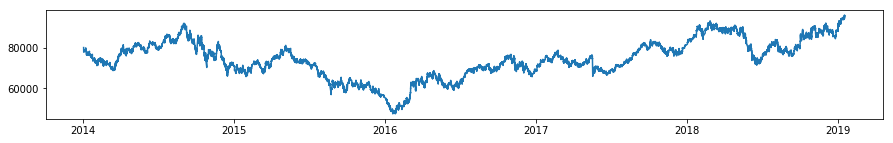

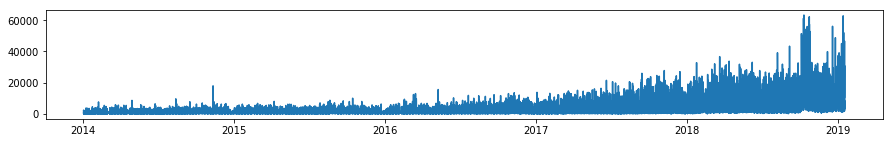

In [22]:
plt.figure(figsize=(15,2))
plt.plot(dow.C) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(dow.RV) # dow.index.map(lambda x: x.year)

In [23]:
dow.RV.head()

time
2014-01-02 10:06:00     481
2014-01-02 10:07:00     184
2014-01-02 10:08:00     139
2014-01-02 10:09:00      43
2014-01-02 10:10:00    1638
Name: RV, dtype: int64

#### Since the data is `exponentially` increasing lets see if we can detrend it.
Lets first use a simple log function

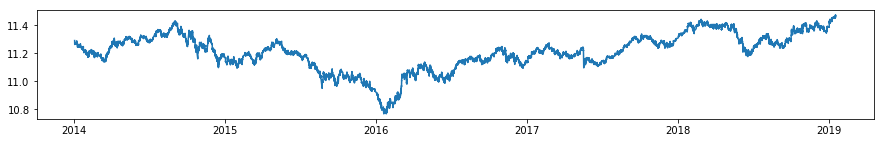

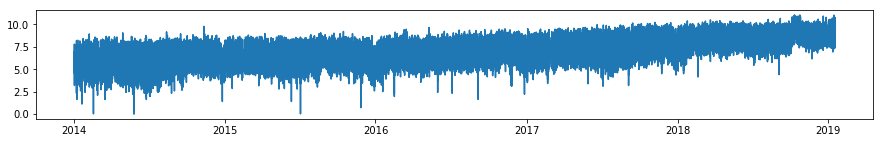

In [24]:
plt.figure(figsize=(15,2))
plt.plot(np.log(dow.C)) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(np.log(dow.RV)) # dow.index.map(lambda x: x.year)

In [25]:
for column in ['TV', 'RV']: # all less the up/down class
    dow.loc[:, column] = np.log(dow.loc[:, column].values+5)

For simplicity a linear detrend to solve the rest.  First try did not pose nice results.  
Use it just for viewing. 

But since we are trying to analyse a specific time-scale 5/6 days all other variations are noise to us. So let's try to remove a moving average of three weeks (3*5=15 days). Need to figure out a better.  

In [26]:
dow.dropna(inplace=True)

In [27]:
from scipy.signal import detrend
dowv = dow.copy()
#dowv.values[:, 4:5] = detrend(dow.values[:,4:5], axis=0, type='linear')

Text(0.5, 1.0, 'Just for viewing data')

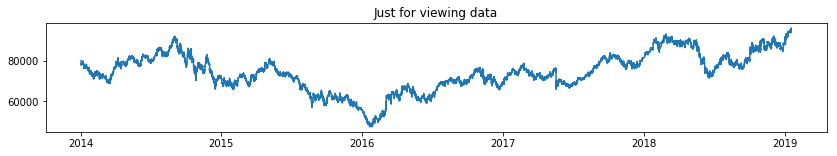

In [28]:
plt.figure(figsize=(14,2))
plt.plot(dowv.C)
plt.title('Just for viewing data')

In [29]:
import talib as ta

In [30]:
len(dow)

509471

In [31]:
# this will need to change to a EMA or SMA due future data dependence
for col in range(6):
    #trend = np.convolve(dow.iloc[:, col], np.ones((15,))/15, mode='valid') 
    trend = ta.SMA(dow.iloc[:, col].values.astype(np.double), 2)
    #dow.iloc[7:-7, col] -= trend # to fit at the center -7 + 7 samples are border
    dow.iloc[:, col] -= trend # to fit at the center -7 + 7 samples are border
# dow.drop(dow.index[:7], inplace=True) # due border effect
# dow.drop(dow.index[-7:], inplace=True)

In [32]:
dow.dropna(inplace=True) # drop first nan value and meaningless UpDown value

In [33]:
len(dow)

509470

In [34]:
dowv = dowv.loc[dow.index] # update the viewing 

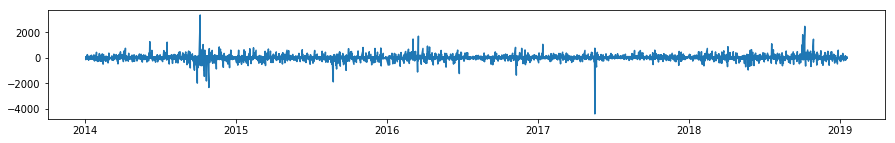

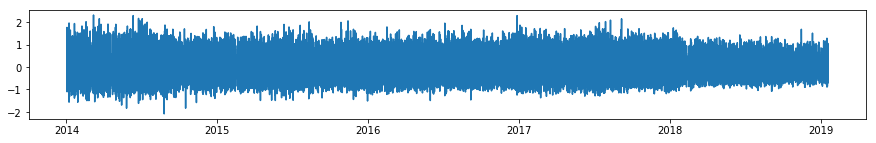

In [35]:
plt.figure(figsize=(15,2))
plt.plot(dow.C) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(dow.RV) # dow.index.map(lambda x: x.year)

For while, let inflation be!   
Will just calculate pattern of candles.   

In [36]:
dow['sup'] = np.nan

We are pushing the days were there were no movement to the down. 

In [37]:
# candles on close
dow.sup.iloc[1:] = dow.iloc[1:].C.values > dow.iloc[:-1].C.values 
dow.sup = dow.sup.map(lambda x: 1 if x else 0)

In [38]:
#dow.sup.values[0] = 0 # first day has no info - but lets not contaminated the mean

Let's drop the first sample due no info and nans on the **trend** removed

In [39]:
dow = dow[1:]
dowv = dowv[1:]

In [40]:
dowv['sup'] = dow.sup.copy()

### Lets Standardize data before creating the training Vector or Feature Vector X

From the histograms we can see there is no class in-balance at first look. 

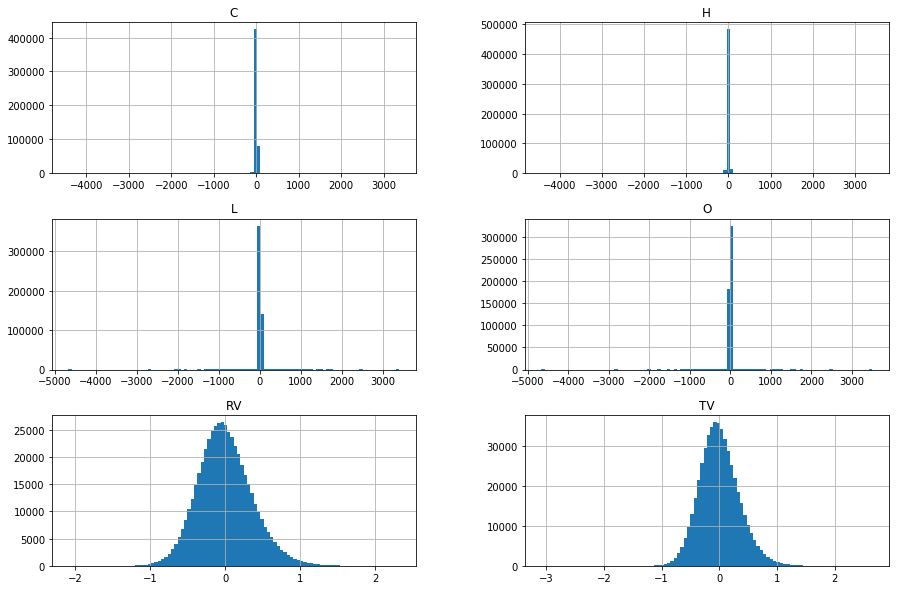

In [41]:
dow.iloc[:, :6].hist(bins=100, figsize=(15,10));

In [42]:
dow.head(1)

,O,H,L,C,TV,RV,updown,sup
time,,,,,,,,
2014-01-02 10:08:00,-19.5,-11.5,-12.0,0.0,0.0146,-0.135967,0,1


In [43]:
newcolumns=dow.columns[:-2].tolist()
newcolumns.extend(['sup', 'updown'])
dow = dow.reindex(columns=newcolumns)
dowv = dowv.reindex(columns=newcolumns)

In [44]:
dow.head(1)

,O,H,L,C,TV,RV,sup,updown
time,,,,,,,,
2014-01-02 10:08:00,-19.5,-11.5,-12.0,0.0,0.0146,-0.135967,1,0


In [45]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [46]:
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=0)

X_trans = quantile_transformer.fit_transform(dow.values[:,:-1])

In [47]:
X_trans.shape

(509469, 7)

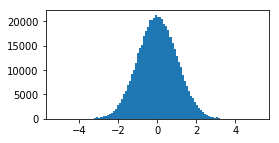

In [48]:
plt.figure(figsize=(4,2))
plt.hist(X_trans[:,4], bins=100);

In [49]:
np.mean(X_trans[:,4]), np.std(X_trans[:,4])

(0.001397940437140695, 0.9955629873310198)

In [50]:
X_trans.shape

(509469, 7)

In [51]:
X = np.array(X_trans)
#X[:,:5] = X_trans[:,:]
#X[:, 5] = dow.values[:,-2]
#X[:, 5] = (X[:, 5] - X[:, 5].mean())/X[:, 5].std() # normalize variance=1 mean=0

In [52]:
np.mean(X, axis=0)

array([-0.00303857, -0.00435987,  0.0020074 , -0.00436415,  0.00139794,
        0.00090943, -0.1559488 ])

In [53]:
np.std(X, axis=0)

array([0.9983418 , 0.99530304, 1.00177219, 0.99960723, 0.99556299,
       0.99804219, 5.19699829])

### Lets make the feature vector X


We will shift forward 5 days so we can use the last ones to predict the next.  
So we can use previous days information to train to predict next one.  

We will train like this:

[-5, -4, -3, -2, -1] -> [0]  
[-4, -3, -2, -1,  0] -> [1]  
[-3, -2, -1,  0,  1] -> [2]  
        ...              
 
but each day O, H, L, C, V will be a row so:

[-5, -4, -3, -2, -1] -> [0]
is  

[O[-5], H[-5], L[-5], C[-5], V[-5], O[-4], H[-4], L[-4], C[-4], V[-4] ... O[-1], H[-1], L[-1], C[-1], V[-1]] -> [0]

Meaning training or feature vector will have 5*5 = 25 dimension. 

In [54]:
data = X # we don't use the training class

In [55]:
pdays=21 # previous hours ~ 5 days on H2 time-frame

In [56]:
data = dow.iloc[:, :-1].values

In [57]:
# data = np.array([1, 3, 4, 5, 6, 3])
# pdays=3

In [58]:
from numba import jit

@jit(nopython=True)
def Xbackward_array(data, nprevious, ncolumns):
    X = np.zeros((len(data)-nprevious+1, nprevious*ncolumns))
    # maybe using np.tile with np.repeat is faster but dont know how
    for i in range(nprevious, len(data)+1):
        X[i-nprevious,:] = data[i-nprevious:i].flatten()
    return X

[1, 3, 4, 5, 6, 3]

[1, 3, 4]  
[3, 4, 5]  
[4, 5, 6]  
[5, 6, 3]  

In [59]:
assert np.alltrue( 
    Xbackward_array(np.array([1, 3, 4, 5, 6, 3]), 3, 1) ==
    np.array([[1, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 3]]))

In [60]:
X = Xbackward_array(data, pdays, 7)

In [61]:
len(X)

509449

### Lets make the class vector or target vector Y

In [62]:
Y = dow.updown[pdays:]
Y = Y.values

In [63]:
len(X), len(Y)

(509449, 509448)

In [64]:
Xfuture = X[-1] # last day/hour is prediction of future
X = X[:-1] # this is training data

In [65]:
dow = dow[pdays:] # the first days dont cannot use class for training so we dont need them
dowv = dowv[pdays:] # same for plotting

In [66]:
import sklearn

In [67]:
print(sklearn.metrics.classification_report(dow.updown, dow.sup))

             precision    recall  f1-score   support

          0       0.80      0.76      0.78    275103
          1       0.73      0.77      0.75    234345

avg / total       0.77      0.77      0.77    509448



In [68]:
#sns.jointplot(dow.updown, dow.sup, kind='kde')

#### Remember!

dowv has same number of row than X, Y vectors, indexes are syncronized

### Lets prepare the engine Torch

In [69]:
import importlib

In [70]:
importlib.reload(torchNN), importlib.reload(torchCV), importlib.reload(torchUtil)

(<module 'algos.nn.torchNN' from '/home/andre/Projects/stocks/algos/nn/torchNN.py'>,
 <module 'algos.nn.torchCV' from '/home/andre/Projects/stocks/algos/nn/torchCV.py'>,
 <module 'algos.nn.torchUtil' from '/home/andre/Projects/stocks/algos/nn/torchUtil.py'>)

In [71]:
device = torchNN.getDevice()

In [72]:
device

device(type='cuda')

In [73]:
torchNN.setSeed(device, 25640) # reproducible

Train in ~ **2 month** and test on the subsequent **0.1 months**

training/valiation ratio of 90%

In [74]:
X, Y = torchUtil.binaryTensors(X, Y, device=device)

In [98]:
ntrain= 60*7*2
kfold = torchCV.sKFold(X, foldsize=ntrain, ratio=0.9)
nsplits = kfold.GetnSplits()
ntrain, ntest, npred = kfold.ntrain, kfold.ntest, kfold.npred
print('number of folds ', nsplits, 
      ' M1 of training ', ntrain, 
      ' M1 of validation ', ntest,
      ' M1 of prediction ', npred)

number of folds  508608  M1 of training  755  M1 of validation  84  M1 of prediction  1


Get a random begin on data of those n years

Locally normalize mean = 0 and variance to 1  
Specially for this 25 type of data/training, this should not be done here. 

In [99]:
#Xfold = (Xfold - Xfold.mean())/Xfold.std() # normalize variance=1 mean=0

In [126]:
# tensors
for start, sval, spred, end in kfold.SplitsRandn(1):
    Xt, yt = X[start:sval], Y[start:sval]
    Xs, ys = X[sval:spred], Y[sval:spred]
    # use :end on slicing to avoid using unsqueze
    Xp, yp = X[spred:end], Y[spred:end] # only ONE sample

#print(start, sval, spred, end)
print('unbalanced class percentage training ~: % {:.1f}'.format(100*((th.sum(yt).item()/(len(yt))-0.5))))
print('unbalanced class percentage validation~: % {:.1f}'.format(100*((th.sum(ys).item()/len(ys))-0.5)))

nnparams = {'nneurons' : [64, 64, 32, 16], 'dropout' : 0.5, 'learn' : 6e-3, 'patience' : 50}
classifier = torchNN.BinaryNN(input_dim=X.shape[1], device=device, **nnparams)

ndata = (len(Xt)+len(Xs))*X.shape[1]
print('Number of params ', classifier.ncells, ' size of data ', ndata)

print('Ratio data size to number of params {:.2f}'.format(classifier.ncells/ndata)) 

unbalanced class percentage training ~: % -4.0
unbalanced class percentage validation~: % -4.8
Number of params  16274  size of data  123333
Ratio data size to number of params 0.13


Awesome post aboute number of params, training samples and overfitting!

https://stats.stackexchange.com/questions/320383/relationship-between-model-over-fitting-and-number-of-parameters/320387#320387

In [127]:
fitparams = {'epochs':9, 'batch':128, 'iscore':0.5, 'gma':0.92, 'verbose':True}
classifier.fit(Xt, yt, Xs, ys, **fitparams);

iteration : 2      train loss: 0.6893941 valid acc: 0.5357143 valid loss :0.6834136 learn r.: 0.0060000
iteration : 5      train loss: 0.6878119 valid acc: 0.5595238 valid loss :0.6775371 learn r.: 0.0055200
iteration : 8      train loss: 0.6860692 valid acc: 0.5595238 valid loss :0.6755232 learn r.: 0.0050784
iteration : 11     train loss: 0.6861148 valid acc: 0.5476190 valid loss :0.6771429 learn r.: 0.0046721
iteration : 14     train loss: 0.6855341 valid acc: 0.5476190 valid loss :0.6785711 learn r.: 0.0042984
iteration : 17     train loss: 0.6841081 valid acc: 0.5476190 valid loss :0.6765848 learn r.: 0.0039545
iteration : 20     train loss: 0.6829527 valid acc: 0.5476190 valid loss :0.6757622 learn r.: 0.0036381
iteration : 23     train loss: 0.6817380 valid acc: 0.5476190 valid loss :0.6752066 learn r.: 0.0033471
iteration : 26     train loss: 0.6806396 valid acc: 0.5595238 valid loss :0.6754249 learn r.: 0.0030793
iteration : 29     train loss: 0.6796194 valid acc: 0.5595238 va

In [128]:
for i in range(2):
    classifier.fineTune(Xs, ys, batch=128)

[################################################################################] 2/2
[################################################################################] 2/2


In [129]:
dow.tail(2)

,O,H,L,C,TV,RV,sup,updown
time,,,,,,,,
2019-01-17 17:53:00,-15.0,-12.5,-17.5,-22.5,-0.035516,0.056515,0,0
2019-01-17 17:54:00,-22.5,-25.0,-42.5,-37.5,0.262313,0.296605,0,0


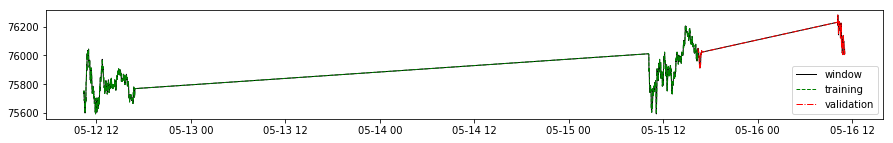

In [130]:
plt.figure(figsize=(15,2))
plt.plot(dowv.iloc[start:end].C, 'k-', lw=1, label='window')
plt.plot(dowv.iloc[start:sval].C, 'g--', label='training', lw=1)
plt.plot(dowv.iloc[sval:end].C, 'r-.', label='validation', lw=1)
plt.legend()

In [131]:
classifier.prog.shape

torch.Size([19, 3])

Using a cut-off on model probability if not certain why should I trust?!  
Try to correct the cases where there is no up or down, just laterall variation or anything else with not that certainty

0.7 or 70% at least

In [132]:
classifier.score(Xs, ys)

0.6428571343421936

In [133]:
params = {'cutoff':0.51}

In [134]:
classifier.score(Xs, ys, **params)

data above probability cutoff: 0.98


0.6341463327407837

To think about...

That above indicates that validation must have a weight.   
Those samples that are more recent should receive a higher 'weight' somehow.

We cannot train too much on a validation set that is too far behind on time. 

Also there are breaking points when the market totally loose correlation from the past.  
For example above near end november.

### Best 78.4% on validation

- `gamma`  should not be too low (~0.9) otherwise we have overfitting on training set 
- a low `gamma` value makes it go to a local minima that is the validation minima

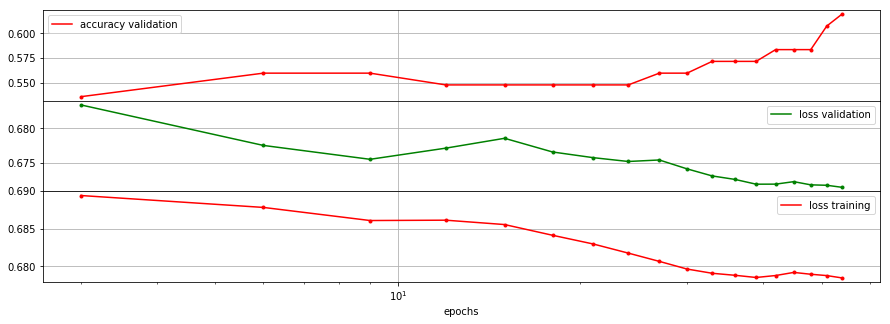

In [135]:
classifier.viewResults()

###  Results

Let's see latest forecasts.

In [136]:
dow.tail(3)

,O,H,L,C,TV,RV,sup,updown
time,,,,,,,,
2019-01-17 17:52:00,-17.5,-15.0,-12.5,-15.0,0.065776,0.011219,1,0
2019-01-17 17:53:00,-15.0,-12.5,-17.5,-22.5,-0.035516,0.056515,0,0
2019-01-17 17:54:00,-22.5,-25.0,-42.5,-37.5,0.262313,0.296605,0,0


### last 10 days / 10 * 2H hours

In [137]:
pdays=10
cutoff=0.5

In [138]:
classifier.score(Xs[-pdays:], ys[-pdays:], cutoff)

data above probability cutoff: 1.00


0.7999999970197678

## Time Now

In [139]:
classifier.predict(th.tensor(Xfuture, dtype=th.float, device=device).unsqueeze(dim=0))

(tensor([[0.5910, 0.4090]], device='cuda:0'), tensor([0], device='cuda:0'))

### Cross validation Sequential Folds 

In [140]:
importlib.reload(torchCV)

<module 'algos.nn.torchCV' from '/home/andre/Projects/stocks/algos/nn/torchCV.py'>

In [141]:
# stand-by dont need this now, better use probabilyties before and test
# to find the best cut-off
# accuracy_clip = lambda m, x, y : torchCV.accuracy(m, x, y, cutoff=0.65)

In [142]:
classifier = torchNN.BinaryNN(input_dim=X.shape[1], device=device, **nnparams)
fitparams['verbose'] = False

#### Run 100 cross-validations on the last n folds

- save predictions as well its probabilities
- pass params using dictionary for 'fit' method

In [164]:
# torchCV.sCrossValidate(X, Y, classifier, foldsize=ntrain, cv=3, 
#                        fit_params=params, scores=[accuracy_clip], predict=True)
results = torchCV.sCrossValidate(X, Y, classifier, foldsize=ntrain, ratio=0.90, cv=200, fine=3, 
                       fit_params=fitparams, kind='randn', predict=True)

[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[####################################

[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[####################################

[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[####################################

[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[####################################

[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 54/54
[################################################################################] 2/2
[################################################################################] 2/2
[####################################

In [165]:
metrics = pd.DataFrame(results, columns=['idx', 'trainac', 'validac', 'accpred', 'predb0', 'predb1', 'y' ])

### Need to run cross-validation again 



In [166]:
metrics.head()

,idx,trainac,validac,accpred,predb0,predb1,y
0,341187.0,0.572271,0.513158,1.0,0.536901,0.463099,0.0
1,330169.0,0.576696,0.644737,1.0,0.480407,0.519593,1.0
2,189588.0,0.563422,0.526316,1.0,0.533079,0.466921,0.0
3,424408.0,0.557522,0.539474,0.0,0.593250,0.406750,1.0
4,33546.0,0.544248,0.539474,0.0,0.592998,0.407002,1.0


In [167]:
metrics.idx = metrics.idx.values.astype(int)
metrics.y = metrics.y.values.astype(int)

#### What is the best cut-off

Better do interactvly cutting and calculating the percentage... of data  
should also vary at the same time the model score to see where is the best  
balance between data-percentage and accuracy. 

In [168]:
np.mean(metrics.accpred)

0.5

In [169]:
metrics['probmax'] = metrics.apply(lambda x:  max(x.predb0, x.predb1), axis=1)

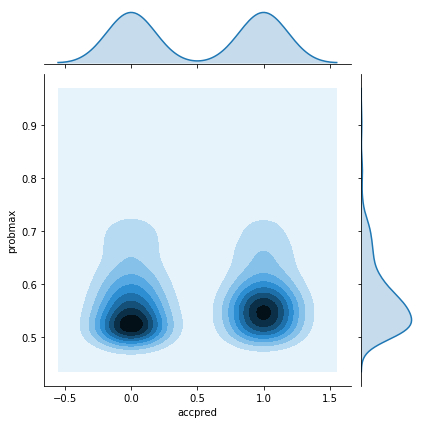

In [170]:
sns.jointplot(metrics.accpred, metrics.probmax, kind='kde')

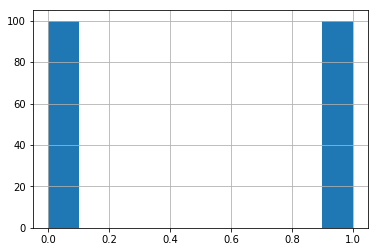

In [171]:
metrics.accpred.hist()

In [172]:
import talib as ta

### Average Accuracy by 5

[0.  0.  0.2 0.6 0.8]


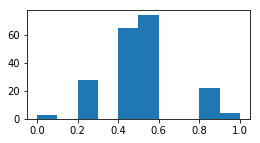

In [173]:
metrics['davpredac'] = ta.SMA(metrics.accpred.values, 5)
plt.figure(figsize=(4,2))
plt.hist(metrics.davpredac.dropna());
print(np.percentile(metrics.davpredac.dropna().values, (0, 1, 10, 50, 90)))
# davpredac_c = ta.SMA(metrics.predac_c.dropna().astype(np.double), 4)
# plt.figure(figsize=(4,2))
# plt.hist(davpredac_c.dropna());
# print(np.percentile(davpredac_c.dropna(), (0, 1, 10, 50, 90)))

In [174]:
metrics['modelscore'] = np.sqrt(metrics.trainac+2*metrics.validac)*metrics.probmax

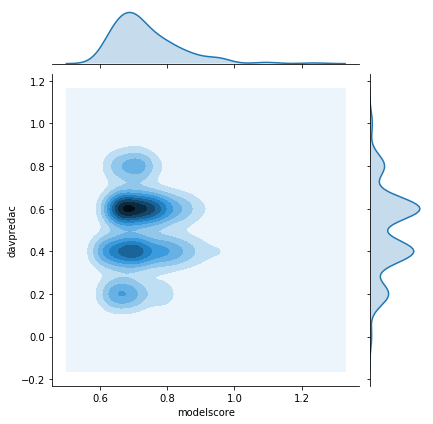

In [175]:
sns.jointplot(metrics.modelscore, metrics.davpredac, kind='kde')

In [182]:
print(np.percentile(metrics.davpredac[ metrics.modelscore > 0.9 ].dropna(), (0, 1, 10, 50, 90)))

[0.    0.026 0.2   0.4   0.74 ]


In [183]:
len(metrics.davpredac[ metrics.modelscore > 0.78 ].dropna())/len(metrics.davpredac.dropna())

0.2602040816326531

In [184]:
metrics[-10:]

,idx,trainac,validac,accpred,predb0,predb1,y,probmax,davpredac,modelscore
190,501360,0.553097,0.539474,0.0,0.490055,0.509945,0,0.509945,0.8,0.651463
191,170677,0.535398,0.486842,0.0,0.529867,0.470133,1,0.529867,0.6,0.650914
192,49396,0.582596,0.552632,1.0,0.653202,0.346798,0,0.653202,0.6,0.848625
193,508944,0.572271,0.513158,1.0,0.681893,0.318107,0,0.681893,0.6,0.862152
194,157065,0.563422,0.578947,1.0,0.535648,0.464352,0,0.535648,0.6,0.702764
195,471819,0.502950,0.500000,0.0,0.494114,0.505886,0,0.505886,0.6,0.620190
196,60560,0.589970,0.539474,0.0,0.662196,0.337804,1,0.662196,0.6,0.855468
197,126102,0.556047,0.578947,0.0,0.535446,0.464554,1,0.535446,0.4,0.700993
198,32391,0.538348,0.473684,1.0,0.506178,0.493822,0,0.506178,0.4,0.616980
199,264155,0.474926,0.539474,0.0,0.701775,0.298225,1,0.701775,0.2,0.874794


In [125]:
def probability(values):
    percentiles = np.percentile(values, [0, 1, 10, 50, 90])
    print('percentiles are ', percentiles)
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(211);
    ax1.hist(values, bins=20, density=True);
    #ax1.set_xlim(percentiles[0], 5)
    ax1.xaxis.set_major_locator(loc)
    ax1.grid()
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.hist(values, bins=20, density=True, cumulative=True);
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('cumulative percentage (%)')
    ax2.grid()

percentiles are  [0.75 0.75 0.75 0.85 0.9 ]


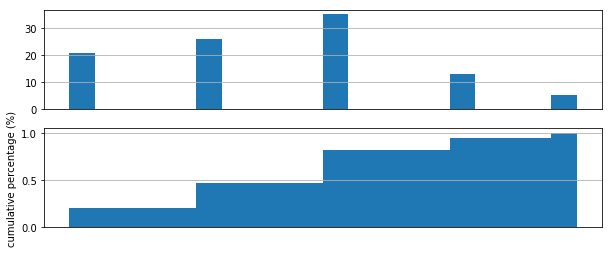

In [126]:
probability(metrics.wavpredac[ metrics.probmax > 0.78 ].dropna());

#### Percent of entries

In [128]:
len(metrics.wavpredac[ metrics.probmax > 0.78 ].dropna())/100

0.77